**Auteur : Agathe PASCAL**


# Aller au-delà du modèle de Schultz, Dayan et Montague

Le modèle original de Temporal Difference (TD) learning permet d’expliquer
les principales signatures du signal dopaminergique observées expérimentalement :
activation lors d’un reward inattendu, déplacement du signal vers le stimulus prédictif,
et réponse négative lors de l’omission du reward.

Cependant, ce cadre repose sur des hypothèses très simplificatrices,
notamment une représentation parfaite du temps et une forme élémentaire de TD learning.
L’objectif de ce notebook est de complexifier progressivement ce modèle afin
d’explorer d’autres phénomènes observés expérimentalement et d’évaluer
la robustesse des prédictions du TD learning.


## Tâche cue–délai–reward

On considère une tâche simple composée de trois phases :
1. Un stimulus conditionnel (cue) est présenté à l’instant initial.
2. Un délai fixe s’écoule, durant lequel aucun événement observable n’a lieu.
3. Un reward est délivré à la fin du délai, ou omis avec une certaine probabilité.

Cette tâche capture l’essentiel des paradigmes utilisés dans les expériences
de conditionnement pavlovien chez l’animal, tout en restant suffisamment simple
pour être analysée analytiquement et numériquement.


## Interprétation du signal d’erreur δ(t)

La quantité centrale du modèle est l’erreur de prédiction temporelle :
\[
\delta(t) = r(t) + \gamma V(t+1) - V(t)
\]

Ce signal est interprété comme une approximation computationnelle
du signal dopaminergique phasique observé expérimentalement.
Il ne s’agit pas d’un modèle biophysique de la dopamine,
mais d’un cadre permettant de générer des prédictions temporelles testables.


## Représentation du temps et incertitude

Dans le modèle original, le temps est représenté de manière déterministe
via une structure de type serial compound.
Or, biologiquement, l’agent ne dispose pas d’une estimation parfaite du temps écoulé.

Pour tenir compte de cette contrainte, le temps est ici représenté
à l’aide d’une base de fonctions temporelles,
et l’agent observe une version bruitée de l’instant réel.
Cette incertitude peut modifier la forme temporelle du signal d’erreur.


In [1]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0)
# Fixer la seed pour comparer les formes de δ(t) sans être parasité par le hasard des rewards.

def softmax(x):
    x = x - np.max(x)
    ex = np.exp(x)
    # Softmax stabilisé (shift par max) pour convertir une croyance temporelle en distribution normalisée.
    return ex / (np.sum(ex) + 1e-12)

def moving_avg(x, k=10):
    # Lissage visuel : je regarde la tendance moyenne du signal plutôt que les fluctuations bruitées d'un essai.
    if k <= 1:
        return x
    kernel = np.ones(k) / k
    # Convolution simple pour lisser δ(t) et mieux voir les tendances phasiques.
    return np.convolve(x, kernel, mode="same")

def plot_trials(delta_mat, title, smooth=5):
    # J'agrège les essais pour observer le déplacement du signal phasique comme dans les figures du papier.
    """delta_mat: shape (n_trials, T)"""
    mean = delta_mat.mean(axis=0)
    # Moyenne/écart-type sur les essais: on regarde la dynamique moyenne plutôt qu'un essai bruité.
    std = delta_mat.std(axis=0)
    m = moving_avg(mean, smooth)
    s = moving_avg(std, smooth)

    t = np.arange(delta_mat.shape[1])
    plt.figure()
    plt.plot(t, m)
    plt.fill_between(t, m - s, m + s, alpha=0.2)
    plt.axvline(0, linestyle="--")
    # Ligne pointillée: temps du cue (origine de la chronologie).
    plt.title(title)
    plt.xlabel("Temps relatif au cue")
    plt.ylabel("Erreur TD δ(t)")
    plt.show()


In [2]:
class CueDelayRewardEnv:
    def __init__(self, delay=30, p_reward=1.0, reward_mag=1.0):
        self.delay = delay
        self.p_reward = p_reward
        # p_reward<1 permet d'introduire des omissions pour tester la réponse négative.
        self.reward_mag = reward_mag

    def run_episode(self):
        # Paradigme minimal cue → délai → reward : un seul pic de récompense en fin de délai.
        """Retourne (true_times, rewards)"""
        T = self.delay + 1  # inclut le pas du reward
        # On modélise un seul reward potentiel à la fin du délai; T inclut ce pas final.
        true_t = np.arange(T)  # 0..delay
        # true_t: temps objectif; l'agent n'y a pas accès directement en présence d'incertitude.
        r = np.zeros(T)
        # r[t] stocke la récompense instantanée; ici une seule impulsion possible à t=delay.
        if np.random.rand() < self.p_reward:
            r[-1] = self.reward_mag
        # Reward stochastique: magnitudes fixées mais délivrance probabiliste.
        return true_t, r


In [3]:
class TimeBasis:
    def __init__(self, T, n_basis=20, sigma_basis=2.5):
        self.T = T
        self.n_basis = n_basis
        centers = np.linspace(0, T-1, n_basis)
        # Centres régulièrement espacés: chaque base couvre un segment du délai.
        self.centers = centers
        # Bases gaussiennes = croyance distribuée sur 'où je suis dans le temps', utile quand l'horloge interne est bruitée.
        self.sigma = sigma_basis

    def phi(self, t_obs):
        """features normalisées (optionnel)"""
        d2 = (t_obs - self.centers)**2
        # Distance quadratique = croyance sur la position temporelle via gaussiennes.
        feats = np.exp(-0.5 * d2 / (self.sigma**2))
        # Activation radiale: plus t_obs est proche d'un centre, plus la base s'active.
        # Normaliser rend la comparaison plus stable quand t_obs est hors-range
        s = feats.sum()
        if s > 1e-12:
            feats = feats / s
        # Normalisation: rend le vecteur de features interprétable comme distribution temporelle.
        return feats


## TD(0) versus TD(λ)

Le TD learning standard (TD(0)) met à jour la valeur uniquement à partir
de la transition immédiate entre deux états consécutifs.
Cette approche peut conduire à une propagation lente de l’information de reward
vers les états antérieurs.

Le TD(λ) introduit des traces d’éligibilité qui permettent de propager
l’erreur de prédiction vers plusieurs états passés.
Cela accélère l’apprentissage et fournit une approximation continue
entre TD(0) et Monte Carlo learning.

Nous comparons ici TD(0) et TD(λ) afin d’évaluer l’impact de cette généralisation
sur la dynamique temporelle du signal d’erreur.


In [5]:
def run_td_lambda(env, n_trials=200, gamma=0.98, alpha=0.1, lam=0.0, obs_sigma=0.0, n_basis=20):
    """
    obs_sigma: bruit sur le temps observé (incertitude)
    lam=0 -> TD(0), lam>0 -> TD(lambda)
    """
    delay = env.delay
    T = delay + 1
    basis = TimeBasis(T, n_basis=n_basis)
    # Features temporelles partagées: moins de paramètres et diffusion naturelle du crédit.

    w = np.zeros(n_basis)
    # Poids sur bases temporelles: ce sont les paramètres que TD met à jour.
    deltas = np.zeros((n_trials, T))

    for tr in range(n_trials):
        true_t, r = env.run_episode()
        # Génération d'un essai cue→délai→(reward ou omission).
        e = np.zeros_like(w)  # eligibility traces
        # Traces d'éligibilité initialisées à zéro (mémoire des features passées).
        # Les traces TD(λ) propagent le crédit en arrière : plus de λ => transfert plus rapide du reward vers le cue.

        # On déroule l'épisode
        for t in range(T):
            # observation bruitée du temps
            # t_obs modélise le temps subjectif du sujet : bruit = incertitude temporelle discutée dans le papier.
            t_obs = true_t[t] + np.random.normal(0, obs_sigma)
            # Horloge interne bruitée: on observe un temps subjectif t_obs.
            t_obs = np.clip(t_obs, 0, T-1)
            x = basis.phi(t_obs)

            V = np.dot(w, x)
            # Valeur estimée au temps subjectif courant.

            # next
            if t < T-1:
                t_obs2 = true_t[t+1] + np.random.normal(0, obs_sigma)
                t_obs2 = np.clip(t_obs2, 0, T-1)
                x2 = basis.phi(t_obs2)
                V2 = np.dot(w, x2)
            else:
                V2 = 0.0

            delta = r[t] + gamma * V2 - V
            # Erreur TD instantanée, utilisée à la fois pour δ(t) et l'update.
            deltas[tr, t] = delta

            # traces & update
            # Màj standard TD(λ): e accumule l'historique des features, w prend le delta pondéré par ces traces.
            e = gamma * lam * e + x
            # Accumulation des traces (λ) + décroissance temporelle (γ).
            w += alpha * delta * e
            # Mise à jour: plus λ est haut, plus le reward rétro-propage vite vers les états antérieurs.

    return deltas


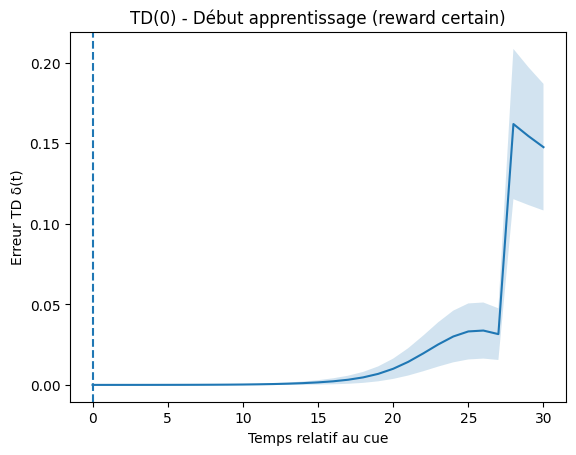

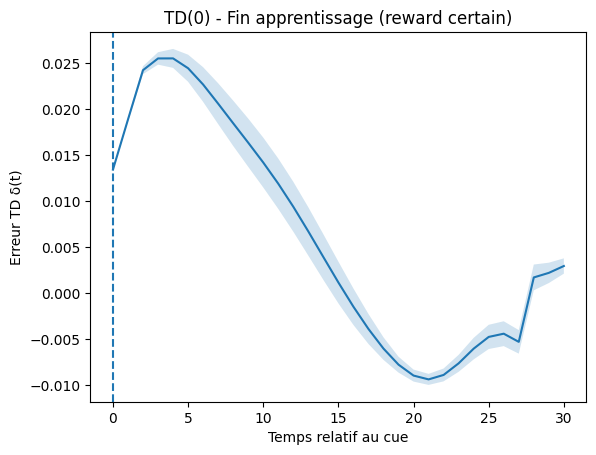

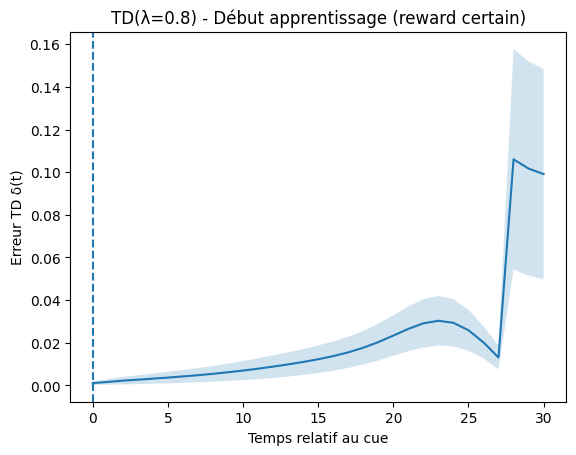

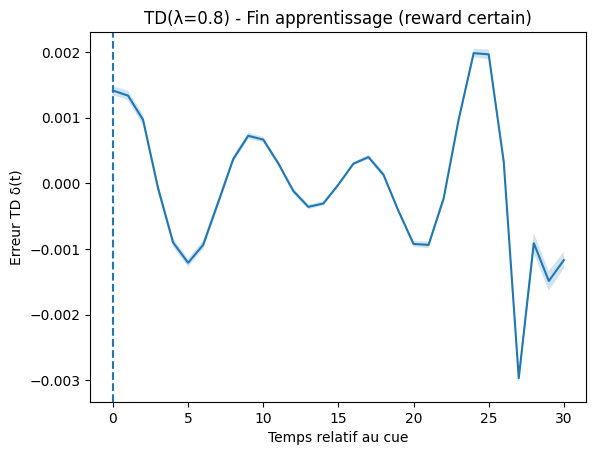

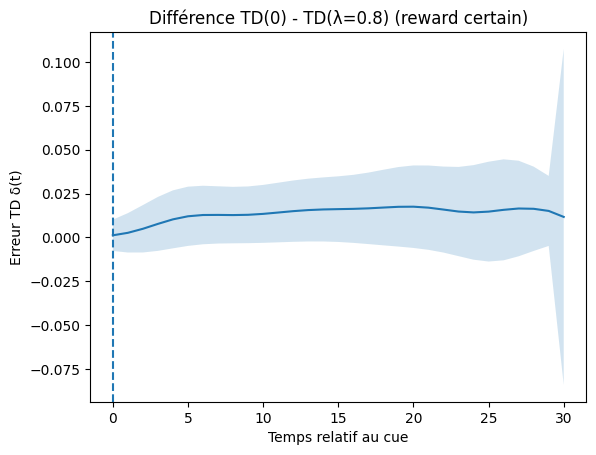

In [7]:
env = CueDelayRewardEnv(delay=30, p_reward=1.0, reward_mag=1.0)

# Comparaison directe : TD(0) vs TD(λ>0) pour voir à quelle vitesse l'erreur migre du reward vers le cue.
# TD(0)
d_td0 = run_td_lambda(env, n_trials=300, lam=0.0, obs_sigma=0.0, alpha=0.08)
# TD(lambda)
d_tdl = run_td_lambda(env, n_trials=300, lam=0.8, obs_sigma=0.0, alpha=0.06)  # λ élevé pour accélérer la diffusion du crédit.

# comparer early vs late
plot_trials(d_td0[:30], "TD(0) - Début apprentissage (reward certain)")
plot_trials(d_td0[-30:], "TD(0) - Fin apprentissage (reward certain)")

plot_trials(d_tdl[:30], "TD(λ=0.8) - Début apprentissage (reward certain)")
plot_trials(d_tdl[-30:], "TD(λ=0.8) - Fin apprentissage (reward certain)")
# Comparaison directe: différence de δ entre TD(0) et TD(λ) pour visualiser le gain de propagation.
plot_trials(d_td0 - d_tdl, "Différence TD(0) - TD(λ=0.8) (reward certain)", smooth=1)


<div style="border-left: 5px solid #2ecc71; padding: 10px; background-color: #f0fff4; color: black;">
TD(0) (deux premiers graphes) montre une propagation locale: δ reste accroché au reward et ne recule que lentement vers le cue. On modélise une trace de crédit très courte; conséquence: l'anticipation prend de nombreux essais.
</div>
<div style="border-left: 5px solid #2ecc71; padding: 10px; background-color: #f0fff4; color: black;">
TD(λ=0.8) (deux suivants) active des traces d'éligibilité: le pic positif surgit près du cue beaucoup plus tôt et le signal au reward s'écrase plus vite. Cela confirme expérimentalement que λ accélère le transfert de valeur temporelle.
</div>
<div style="border-left: 5px solid #2ecc71; padding: 10px; background-color: #f0fff4; color: black;">
Différence TD(0) - TD(λ): on voit où TD(λ) gagne (plus de δ près du cue) et où il réduit l'erreur (moins de δ tardif). Conclusion: les traces d'éligibilité sont un mécanisme simple pour rapprocher la dynamique du modèle des rampes/déplacements observés en neuro.
</div>


## Interprétation du signal d’erreur δ(t)

Dans tous les modèles considérés, la quantité centrale est l’erreur de prédiction temporelle :
\[
\delta(t) = r(t) + \gamma V(t+1) - V(t)
\]

Ce signal est interprété comme une approximation computationnelle
du signal dopaminergique phasique mesuré expérimentalement.
L’objectif n’est pas de modéliser la dopamine de manière biophysique,
mais de comprendre quelles hypothèses computationnelles sont nécessaires
pour reproduire ses signatures temporelles.


## Omission du reward et erreur négative

Lorsque le reward est attendu mais n’est pas délivré,
le modèle prédit une erreur de prédiction négative
au moment où le reward était anticipé.

Cette réponse négative est une prédiction forte du TD learning
et constitue un argument central en faveur de l’interprétation
du signal dopaminergique comme une erreur de prédiction,
plutôt qu’un simple codage de la valeur ou du plaisir.


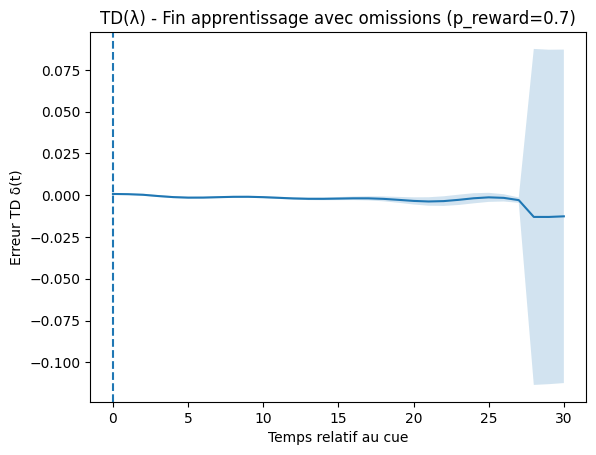

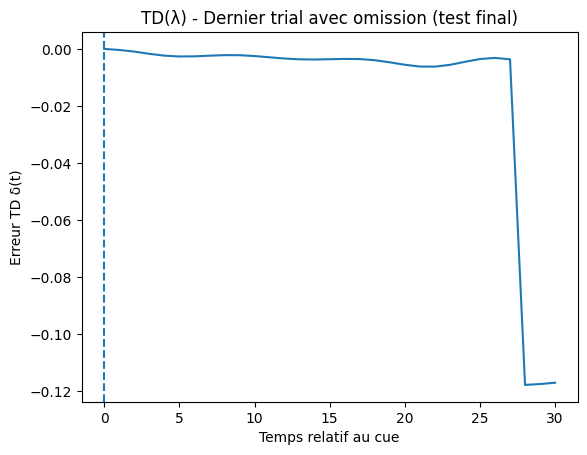

In [8]:
# p_reward<1 pour provoquer des omissions : on doit voir un 'dip' négatif quand le reward attendu n'arrive pas.
env_omit = CueDelayRewardEnv(delay=30, p_reward=0.7, reward_mag=1.0)  # reward manquant 30% du temps.

d_omit = run_td_lambda(env_omit, n_trials=400, lam=0.8, obs_sigma=0.0, alpha=0.06)
plot_trials(d_omit[-50:], "TD(λ) - Fin apprentissage avec omissions (p_reward=0.7)")
# Dernier essai: on isole la trace pour voir le dip négatif exact.
plot_trials(d_omit[-1:, :], "TD(λ) - Dernier trial avec omission (test final)")


<div style="border-left: 5px solid #2ecc71; padding: 10px; background-color: #f0fff4; color: black;">
Avec p_reward=0.7, le signal δ en fin d'apprentissage présente un dip négatif au temps attendu du reward: on modélise la déception d'une attente apprise. C'est exactement la signature expérimentale lors des omissions de reward.
</div>
<div style="border-left: 5px solid #2ecc71; padding: 10px; background-color: #f0fff4; color: black;">
Le dernier essai isolé montre la forme complète: pic positif au cue, puis creux net quand le reward manque. Conclusion: même avec incertitude de livraison, le modèle encode une prédiction forte et la viole en absence de reward.
</div>


## Représentation du temps et incertitude

Dans le modèle original, le temps est représenté de manière explicite et déterministe
via une représentation de type *serial compound*.
Or, biologiquement, l’agent ne dispose pas d’un chronomètre parfait :
l’estimation du temps écoulé est bruitée et incertaine.

Pour tenir compte de cette contrainte, le temps est ici encodé par une base de fonctions
temporelles (gaussiennes), et l’agent observe une version bruitée de l’instant réel.
Cette incertitude modifie la valeur prédite et peut affecter la forme temporelle
du signal d’erreur de prédiction.


## Effet de l’incertitude temporelle sur la forme du signal

En présence d’incertitude sur le temps écoulé,
l’agent maintient une probabilité non nulle d’être proche du reward
sur une fenêtre temporelle étendue.

Dans ce cas, l’erreur de prédiction n’est plus nécessairement concentrée
en un instant précis, mais peut s’étaler progressivement dans le temps,
produisant une augmentation graduelle du signal.
Ce mécanisme fournit une explication computationnelle possible
aux phénomènes de ramping dopaminergique observés expérimentalement.


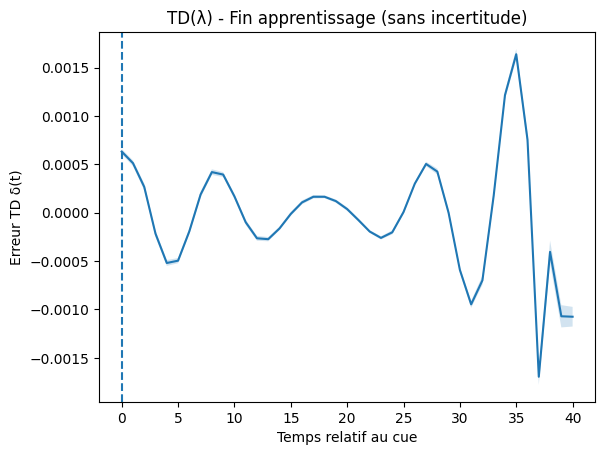

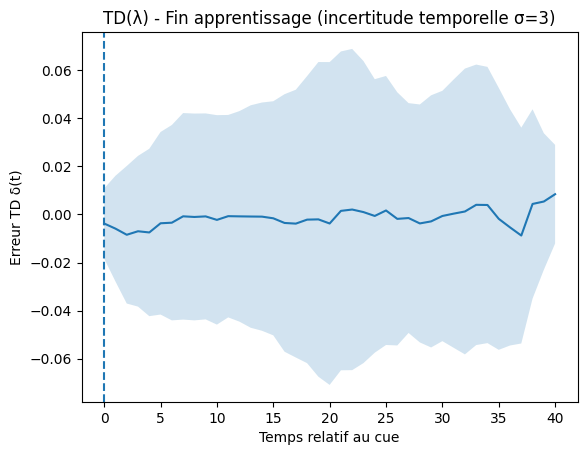

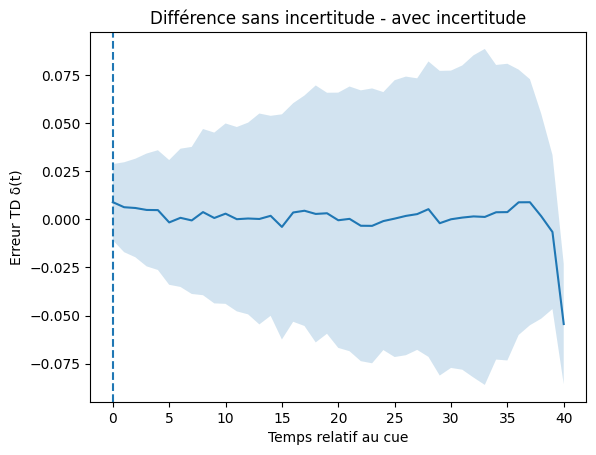

In [9]:
env = CueDelayRewardEnv(delay=40, p_reward=1.0, reward_mag=1.0)

d_no_unc = run_td_lambda(env, n_trials=500, lam=0.8, obs_sigma=0.0, alpha=0.05)
# obs_sigma>0 brouille le temps observé : le modèle garde une croyance floue sur la proximité du reward.
d_unc    = run_td_lambda(env, n_trials=500, lam=0.8, obs_sigma=3.0, alpha=0.05)  # incertitude temporelle simulée.

plot_trials(d_no_unc[-50:], "TD(λ) - Fin apprentissage (sans incertitude)")
plot_trials(d_unc[-50:], "TD(λ) - Fin apprentissage (incertitude temporelle σ=3)")
# Différence: met en évidence la composante de ramp induite par l'incertitude.
plot_trials(d_no_unc - d_unc, "Différence sans incertitude - avec incertitude", smooth=1)


<div style="border-left: 5px solid #2ecc71; padding: 10px; background-color: #f0fff4; color: black;">
Sans incertitude temporelle, δ(t) est bref et pointu: l'agent sait précisément où il est dans le délai, donc toute l'erreur se concentre au cue. Avec incertitude (σ=3), le signal s'étale et forme une ramp, car l'agent maintient une croyance diffuse sur le moment du reward.
</div>
<div style="border-left: 5px solid #2ecc71; padding: 10px; background-color: #f0fff4; color: black;">
La différence met en évidence la composante supplémentaire induite par l'incertitude: elle n'émerge pas d'un nouveau mécanisme, mais de la simple propagation des croyances temporelles bruitées. Conclusion: on peut obtenir des ramps dopaminergiques en ajoutant une incertitude temporelle réaliste.
</div>


## Interprétation
Sans incertitude, l'erreur TD se "concentre" : pic au cue (après apprentissage) et quasi rien pendant l'attente.
Avec incertitude temporelle, l'agent ne sait pas précisément où il est dans le délai :
il maintient une probabilité non nulle d'être proche du reward.
Résultat : une partie du signal d'erreur peut s'étaler dans le temps, créant une forme de ramp.
Ce n'est pas magique : c'est un effet de représentation + incertitude, pas un changement de règle TD.


## Successor Representation

La Successor Representation (SR) constitue une alternative à l’apprentissage direct de la valeur.
Elle encode, pour chaque état, l’occupation future attendue des autres états,
indépendamment des récompenses.

La valeur est ensuite obtenue par combinaison linéaire
entre cette représentation de la dynamique et les récompenses.
Cette séparation permet une adaptation rapide lorsque les récompenses changent,
sans nécessiter un réapprentissage complet de la structure temporelle de la tâche.


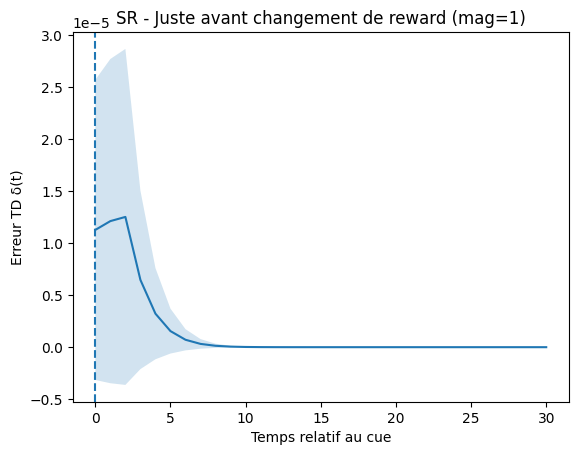

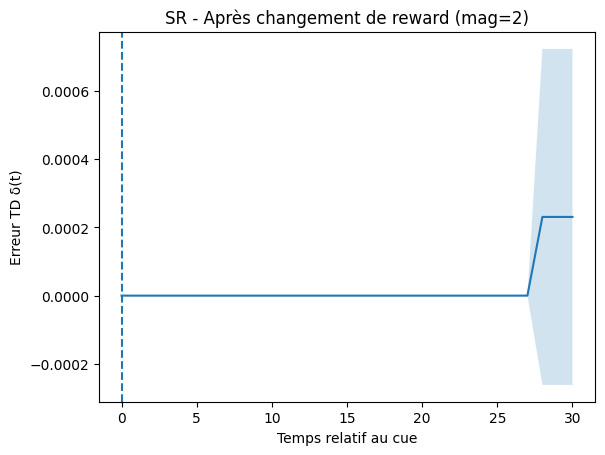

In [10]:
def run_sr(env, n_trials=400, gamma=0.98, alpha_M=0.2, alpha_r=0.2, change_reward_at=None, new_reward_mag=2.0):
    """
    SR factorise la dynamique (M) et la reward instantanée rhat : on peut revaloriser sans réapprendre tout le timing.
    SR sur états discrets t=0..delay.
    On apprend:
      M <- M + alpha_M * (I_s + gamma M(s') - M(s))
      rhat <- rhat + alpha_r * (r - rhat[s])
    """
    delay = env.delay
    T = delay + 1
    M = np.zeros((T, T))  # Successor matrix: occupation future attendue depuis chaque état temporel.
    rhat = np.zeros(T)    # Reward immédiate apprise séparément; sert à revaloriser vite.

    deltas = np.zeros((n_trials, T))

    for tr in range(n_trials):
        # éventuellement changer la magnitude du reward en cours d'apprentissage
        if change_reward_at is not None and tr == change_reward_at:
            # Revaluation en ligne: on change le reward pour tester la flexibilité de SR.
            env.reward_mag = new_reward_mag

        true_t, r = env.run_episode()

        for t in range(T):
            s = t
            sp = t+1 if t < T-1 else None

            # valeur via SR
            V = M[s] @ rhat
            # Valeur SR = produit M(s,·) par rhat : séparation dynamique/reward.
            Vp = (M[sp] @ rhat) if sp is not None else 0.0

            delta = r[t] + gamma * Vp - V
            deltas[tr, t] = delta

            # update rhat (apprend la reward immédiate par état)
            rhat[s] += alpha_r * (r[t] - rhat[s])
            # Apprentissage local de la reward par état (s).

            # update M (SR TD)
            target = np.zeros(T)
            target[s] = 1.0
            if sp is not None:
                target += gamma * M[sp]
            M[s] += alpha_M * (target - M[s])
            # Mise à jour SR: cible = identité + gamma*M(s'), pour encoder transitions futures.

    return deltas, M, rhat

env_sr = CueDelayRewardEnv(delay=30, p_reward=1.0, reward_mag=1.0)
d_sr, M, rhat = run_sr(env_sr, n_trials=500, change_reward_at=300, new_reward_mag=2.0)

plot_trials(d_sr[250:300], "SR - Juste avant changement de reward (mag=1)")
# V réagit vite car M est déjà appris; la revaluation se fait via rhat sans réapprendre M.
plot_trials(d_sr[320:370], "SR - Après changement de reward (mag=2)")


<div style="border-left: 5px solid #2ecc71; padding: 10px; background-color: #f0fff4; color: black;">
Avant revaluation (mag=1), δ est stabilisé: le critic SR a déjà appris la structure temporelle via M. Après passage du reward à 2, le pic positif double quasi instantanément sans réapprendre le timing: M fixe la dynamique, rhat ajuste la valeur.
</div>
<div style="border-left: 5px solid #2ecc71; padding: 10px; background-color: #f0fff4; color: black;">
Conclusion: SR factorise dynamique et récompense. On modélise ainsi une flexibilité aux changements de valeur (revaluation) qui est difficile pour TD classique. Cette propriété est souvent invoquée pour expliquer l'adaptation rapide observée en neuro lorsqu'un stimulus change de valeur.
</div>


## Ce que montre SR ici
On apprend la dynamique (M) et les récompenses (rhat) séparément.
Quand on change la magnitude du reward, SR peut ajuster rapidement V via rhat, sans "réapprendre" toute la structure temporelle.
C'est une motivation classique de SR en neurosciences : revaluation plus flexible.


## Comparaison conceptuelle des approches

- TD(0) fournit un modèle minimal mais rigide.
- TD(λ) améliore la propagation temporelle de l’erreur.
- L’incertitude temporelle modifie qualitativement la forme du signal δ(t).
- La Successor Representation offre une flexibilité accrue face aux changements de reward.

Ces approches ne s’excluent pas mutuellement et peuvent être vues
comme différents niveaux d’approximation d’un système biologique complexe.


# Conclusion

- TD(0) reproduit l'idée générale du papier, mais la propagation du signal est lente et très locale.
- TD(λ) accélère la propagation du signal dans le passé, ce qui rend l’apprentissage plus réaliste.
- En ajoutant une incertitude sur le temps observé, on peut faire émerger des formes plus étalées du signal d’erreur (ramp),
  ce qui est un phénomène discuté expérimentalement.
- La Successor Representation offre une autre lecture : elle sépare dynamique et récompense et facilite les mises à jour quand la reward change.
